In [1]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
from tqdm import tqdm

In [2]:
from matplotlib import rc
rc('text', usetex=True)
rc('text.latex', unicode=True)
rc('text.latex', preamble=r'\usepackage[russian]{babel}')

/home/vasily/.virtualenvs/cnn_course/lib/python3.6/site-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2.
  This is separate from the ipykernel package so we can avoid doing imports until


# 1. Набор данных CAMUS

In [3]:
from echo_lv.data import LV_CAMUS_Dataset

In [4]:
data_lv = LV_CAMUS_Dataset(classes={0, 1},
                           patient_qualities={'Good', 'Medium', 'Poor'},
                           heart_states={'ED', 'ES'},
                           views={'2CH', '4CH'},
                           image_qualities={'Good', 'Medium', 'Poor'},
                           shuffle=False,
                           folds = 9
                          )

In [5]:
print(data_lv.get_num_all_frames())

19232


## 1.1 Статистики по пациентам

In [6]:
data_lv.df_patients['quality'].value_counts() / len(data_lv.df_patients)

Medium    0.462222
Good      0.351111
Poor      0.186667
Name: quality, dtype: float64

In [7]:
ef_dist = {'<=45': 0, '>=55': 0, 'else': 0}
ef_dist['<=45'] = len(data_lv.df_patients[(data_lv.df_patients['ef'] <= 45)]) / len(data_lv.df_patients)
ef_dist['>=55'] = len(data_lv.df_patients[(data_lv.df_patients['ef'] >= 55)]) / len(data_lv.df_patients)
ef_dist['else'] = len(data_lv.df_patients[(data_lv.df_patients['ef'] > 45) & (data_lv.df_patients['ef'] < 55)]) / len(data_lv.df_patients)
for key in ef_dist.keys():
    print(key, '   ', '{:.3f}'.format(ef_dist[key]))

<=45     0.264
>=55     0.447
else     0.289


## 1.2 Статистики по изображениям

In [8]:
data_lv.df_images['img_shape'].value_counts().head(10) / 1800

(630, 1038)    0.144444
(551, 908)     0.111111
(512, 843)     0.100000
(590, 973)     0.072222
(669, 1103)    0.055556
(748, 1232)    0.054444
(669, 1102)    0.050000
(591, 973)     0.046667
(472, 779)     0.038889
(708, 1168)    0.037778
Name: img_shape, dtype: float64

In [9]:
260 / 1800

0.14444444444444443

In [10]:
data_lv.df_images['img_shape'].max()

(1181, 1945)

In [11]:
data_lv.df_images['img_shape'].min()

(323, 649)

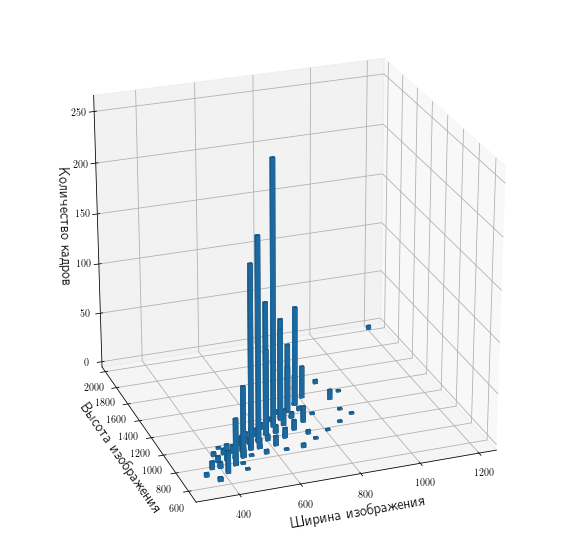

In [15]:
w, h, n = [], [], []
for it in data_lv.df_images['img_shape'].value_counts().iteritems():
    w.append(it[0][0])
    h.append(it[0][1])
    n.append(it[1])

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
ax.bar3d(w, h, np.zeros(len(w)), 15*np.ones(len(w)), 15*np.ones(len(w)), n, zsort='average')
# ax.set_xlim(0)
# ax.set_ylim(0)
# ax.set_xlabel('image width')
# ax.set_ylabel('image  height')
# ax.set_zlabel('number of images')
ax.set_xlabel('Ширина изображения', fontsize=15)
ax.set_ylabel('Высота изображения', fontsize=15)
ax.set_zlabel('Количество кадров', fontsize=15)
ax.view_init(25, 250)
plt.savefig('figures/dist_size_camus.png', dpi=300, bbox_inches='tight', pad_inches=0)

In [16]:
data_lv.df_images['quality'].value_counts()

Good      916
Medium    682
Poor      202
Name: quality, dtype: int64

In [17]:
data_lv.df_images['quality'].value_counts() / len(data_lv.df_images)

Good      0.508889
Medium    0.378889
Poor      0.112222
Name: quality, dtype: float64

In [18]:
data_lv.df_images

,patient,heart_state,view,quality,img_shape,img_name,msk_name,fold
0,patient0001,ED,2CH,Good,"(549, 778)",patient0001_2CH_ED.mhd,patient0001_2CH_ED_gt.mhd,0
1,patient0001,ES,2CH,Good,"(549, 778)",patient0001_2CH_ES.mhd,patient0001_2CH_ES_gt.mhd,0
2,patient0001,ED,4CH,Good,"(549, 778)",patient0001_4CH_ED.mhd,patient0001_4CH_ED_gt.mhd,0
3,patient0001,ES,4CH,Good,"(549, 778)",patient0001_4CH_ES.mhd,patient0001_4CH_ES_gt.mhd,0
4,patient0002,ED,2CH,Medium,"(748, 1167)",patient0002_2CH_ED.mhd,patient0002_2CH_ED_gt.mhd,0
...,...,...,...,...,...,...,...,...
1795,patient0449,ES,4CH,Medium,"(433, 714)",patient0449_4CH_ES.mhd,patient0449_4CH_ES_gt.mhd,8
1796,patient0450,ED,2CH,Good,"(869, 1232)",patient0450_2CH_ED.mhd,patient0450_2CH_ED_gt.mhd,8
1797,patient0450,ES,2CH,Good,"(869, 1232)",patient0450_2CH_ES.mhd,patient0450_2CH_ES_gt.mhd,8
1798,patient0450,ED,4CH,Good,"(748, 1232)",patient0450_4CH_ED.mhd,patient0450_4CH_ED_gt.mhd,8


## Кадры и маски

In [19]:
img, msk, full_msk, weighted_msk, segment_mask, *_ = data_lv[204]
plt.figure(figsize=(20,7))
plt.subplot(151)
plt.imshow(np.squeeze(img), cmap=plt.cm.gray)
cv2.imwrite('imgs/us_image_camus.png', (np.squeeze(img)*255).astype(np.uint8))
plt.subplot(152)
plt.imshow(np.squeeze(full_msk))
cv2.imwrite('imgs/us_mask_camus.png', (np.squeeze(full_msk) / np.max(full_msk) * 255).astype(np.uint8))
plt.subplot(153)
plt.imshow(np.squeeze(msk))
plt.subplot(154)
plt.imshow(np.squeeze(weighted_msk))
plt.subplot(155)
plt.imshow(segment_mask)

AttributeError: 'LV_CAMUS_Dataset' object has no attribute 'obj'

In [32]:
from skimage.transform import resize
sz = []
for it in tqdm(range(len(data_lv)), total=len(data_lv)):
    img, msk, full_msk, weighted_msk, segment_mask, *_ = data_lv[it]
    segment_mask = resize(segment_mask, (256, 256), preserve_range=True, anti_aliasing=False, order=0)
    area = np.sum(segment_mask)
    if area > 39000:
        break
    sz.append(area)

 11%|█▏        | 204/1800 [00:08<01:03, 25.27it/s]


In [36]:
l = []
l += ['a', 'b', 'c']
l += ['a', 'b', 'c']

In [37]:
l

['a', 'b', 'c', 'a', 'b', 'c']

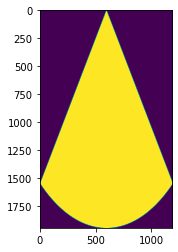

In [27]:
plt.imshow(segment_mask)

(array([  82.,   86., 1542.,    0.,   70.,    0.,    8.,    0.,    0.,
          12.]),
 array([34022. , 34578.4, 35134.8, 35691.2, 36247.6, 36804. , 37360.4,
        37916.8, 38473.2, 39029.6, 39586. ]),
 <a list of 10 Patch objects>)

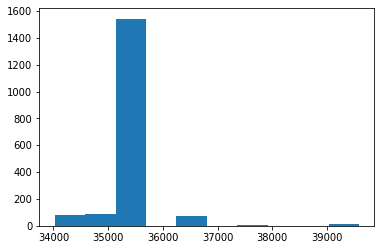

In [31]:
plt.hist(sz)

 ## Анализ подвыборок

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f7286d4f8d0>,
      dtype=object)

<Figure size 1440x1440 with 0 Axes>

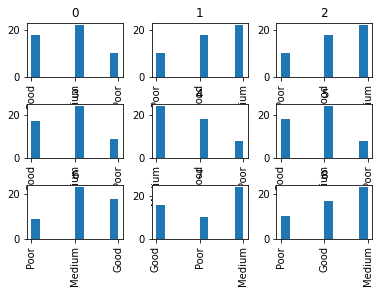

In [25]:
plt.figure(figsize=(20,20))
data_lv.df_patients.hist(column='quality', by='fold')

# 2. Набор данных ЕКБ

In [20]:
from echo_lv.data import LV_EKB_Dataset

In [21]:
data_lv = LV_EKB_Dataset(dataset_path='../datasets/us_ekb',img_size=(512,512))

Dataset is correct.


## 2.1 Статистика по пациентам

In [22]:
data_lv.df_patients

,patient,category,img_shape,num_frames
0,01,DKMP,"(600, 800)",34
1,02,DKMP,"(644, 832)",29
2,03,DKMP,"(644, 832)",35
3,04,DKMP,"(600, 800)",34
4,05,DKMP,"(600, 800)",63
...,...,...,...,...
89,48,Pathology_Old,"(480, 640)",27
90,49,Pathology_Old,"(480, 640)",28
91,50,Pathology_Old,"(240, 320)",35
92,51,Pathology_Old,"(480, 640)",29


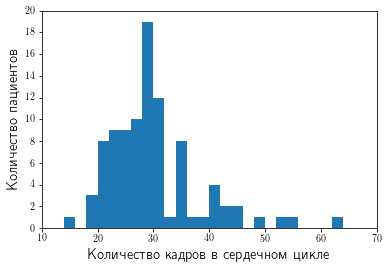

In [28]:
plt.hist(data_lv.df_patients['num_frames'], bins=30, range=(10,70));
plt.ylim(0,20)
plt.xlim(10,70)
plt.yticks(range(0,21,2))
plt.xlabel('Количество кадров в сердечном цикле', fontsize=15)
plt.ylabel('Количество пациентов', fontsize=15)
plt.savefig('figures/dist_sequence_usekb.png', dpi=300, bbox_inches='tight', pad_inches=0)

In [25]:
data_lv.df_patients['category'].value_counts() / len(data_lv.df_patients)

Pathology_Old    0.553191
Norma_Old        0.255319
Norma            0.138298
DKMP             0.053191
Name: category, dtype: float64

In [26]:
data_lv.df_images['img_shape'].value_counts() / len(data_lv.df_images)

(480, 640)    0.524720
(600, 800)    0.252616
(240, 320)    0.199567
(644, 832)    0.023096
Name: img_shape, dtype: float64

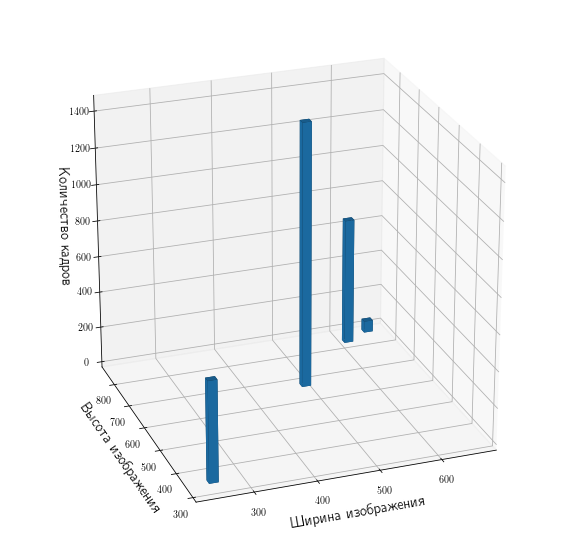

In [27]:
w, h, n = [], [], []
for it in data_lv.df_images['img_shape'].value_counts().iteritems():
    w.append(it[0][0])
    h.append(it[0][1])
    n.append(it[1])
    
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
ax.bar3d(w, h, np.zeros(len(w)), 15*np.ones(len(w)), 15*np.ones(len(w)), n, zsort='average')
# ax.set_xlim(0)
# ax.set_ylim(0)
ax.set_xlabel('Ширина изображения', fontsize=15)
ax.set_ylabel('Высота изображения', fontsize=15)
ax.set_zlabel('Количество кадров', fontsize=15)
ax.view_init(25, 250)
plt.savefig('figures/dist_size_usekb.png', dpi=300, bbox_inches='tight', pad_inches=0)

False

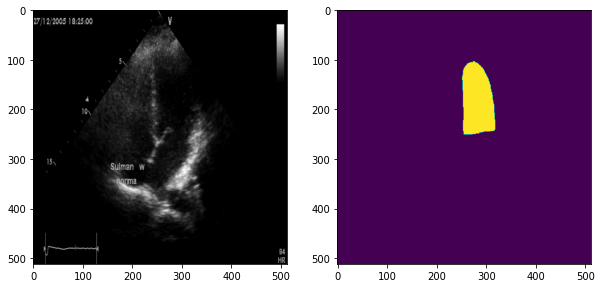

In [27]:
img, msk = data_lv[280]
img = np.squeeze(img)
msk = np.squeeze(msk)
plt.figure(figsize=(10,10))
plt.subplot(121)
plt.imshow(img, cmap=plt.cm.gray)
cv2.imwrite('imgs/us_image_ekb.png', img)
plt.subplot(122)
plt.imshow(msk)
cv2.imwrite('imgs/us_mask_ekb.png', msk)

In [32]:
cont

(array([255, 255, 254, 255, 255, 254, 254, 254, 254, 253, 254, 254, 254,
        253, 253, 253, 254, 253, 254, 254, 253, 254, 254, 253, 254, 253,
        254, 253, 254, 254, 255, 255, 255, 255, 254, 255, 255, 255, 255,
        255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255,
        255, 255, 255, 254, 254, 254, 254, 254, 254, 254, 254, 254, 254,
        254, 254, 254, 254, 254, 254, 254, 254, 254, 254, 254, 254, 254,
        254, 254, 254, 254, 254, 254, 254, 254, 254, 254, 254, 253, 253,
        253, 253, 253, 253, 253, 253, 253, 253, 253, 253, 253, 253, 253,
        253, 253, 253, 253, 253, 252, 253, 252, 252, 252, 252, 252, 252,
        253, 253, 253, 253, 254, 254, 254, 254, 254, 254, 254, 254, 254,
        255, 255, 255, 256, 256, 257, 258, 258, 259, 260, 261, 262, 262,
        263, 264, 265, 266, 267, 268, 269, 270, 271, 272, 273, 274, 274,
        275, 276, 277, 277, 278, 279, 280, 281, 282, 283, 284, 285, 285,
        286, 287, 288, 289, 289, 290, 291, 292, 293

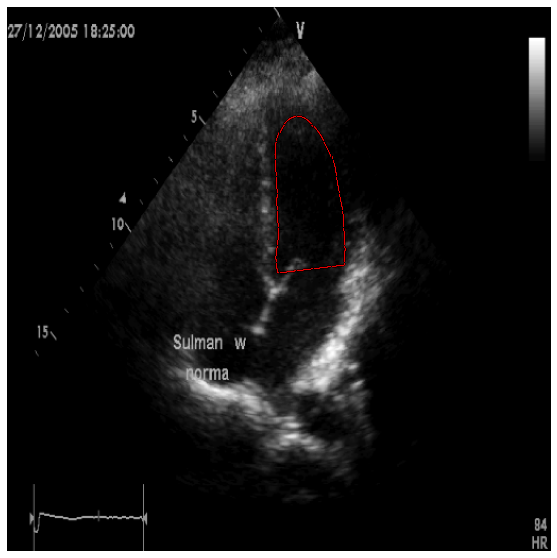

In [54]:
from echo_lv.lv import get_contour_points, interpolate_contour
plt.figure(figsize=(10,10))
plt.axis('off')
cont_x, cont_y, *_ = get_contour_points(msk, kind='contour', num=20)
cont_x, cont_y = interpolate_contour(cont_x, cont_y)
plt.imshow(img, cmap=plt.cm.gray)
plt.scatter(cont_x, cont_y, s = 0.1, c = 'r', marker='.', alpha=0.2)
plt.savefig('figures/example_us.png', bbox_inches='tight', pad_inches=0)

In [ ]:
lv.df_patients['e'] = None

In [ ]:
config = configparser.ConfigParser()
config.read('../datasets/us_camus/training/patient0001/info_2CH.cfg')

In [ ]:
image_itk.GetMetaData('Quality')

## Check normal and DKMP patient

In [68]:
from echo_lv.lv import area2cont

367
Площадь:  15905


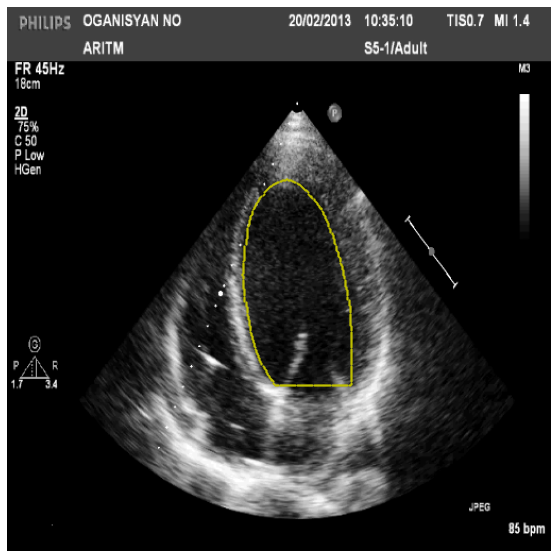

In [99]:
for i, obj in enumerate(data_lv.df_images.iterrows()):
    if obj[1]['category'] == 'DKMP' and obj[1]['patient'] == '01' and obj[1]['obj_name'] == '01.bmp':
        print(i)
        break
cont = area2cont(np.squeeze(data_lv[i][1]))
y,x =np.where(cont!=0)
plt.figure(figsize=(10,10))
plt.imshow(np.squeeze(data_lv[i][0]),cmap=plt.cm.gray)
plt.scatter(x,y,c='y',s=5,marker='.')
plt.axis('off')
print('Площадь: ', len(np.where(np.squeeze(data_lv[i][1]) != 0)[0]))
plt.savefig('figures/pat_dkmp_diast.png', bbox_inches='tight', pad_inches=0,)

1878
Площадь:  14944


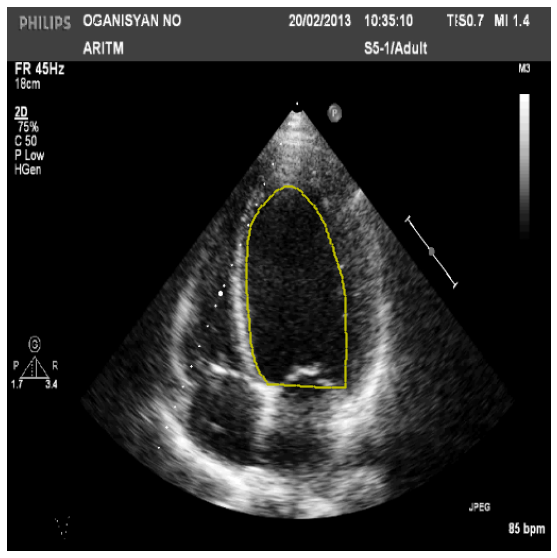

In [100]:
for i, obj in enumerate(data_lv.df_images.iterrows()):
    if obj[1]['category'] == 'DKMP' and obj[1]['patient'] == '01' and obj[1]['obj_name'] == '11.bmp':
        print(i)
        break
cont = area2cont(np.squeeze(data_lv[i][1]))
y,x =np.where(cont!=0)
plt.figure(figsize=(10,10))
plt.imshow(np.squeeze(data_lv[i][0]),cmap=plt.cm.gray)
plt.scatter(x,y,c='y',s=5,marker='.')
plt.axis('off')
print('Площадь: ', len(np.where(np.squeeze(data_lv[i][1]) != 0)[0]))
plt.savefig('figures/pat_dkmp_syst.png', bbox_inches='tight', pad_inches=0,)

2321
Площадь:  13225


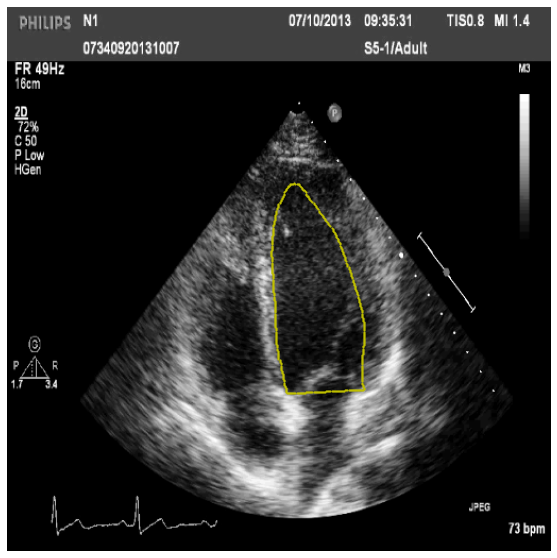

In [89]:
for i, obj in enumerate(data_lv.df_images.iterrows()):
    if obj[1]['category'] == 'Norma' and obj[1]['patient'] == '01' and obj[1]['obj_name'] == '01.bmp':
        print(i)
        break
cont = area2cont(np.squeeze(data_lv[i][1]))
y,x =np.where(cont!=0)
plt.figure(figsize=(10,10))
plt.imshow(np.squeeze(data_lv[i][0]),cmap=plt.cm.gray)
plt.scatter(x,y,c='y',s=5,marker='.')
plt.axis('off')
print('Площадь: ', len(np.where(np.squeeze(data_lv[i][1]) != 0)[0]))
plt.savefig('figures/pat_norma_diast.png', bbox_inches='tight', pad_inches=0,)

2229
Площадь:  9717


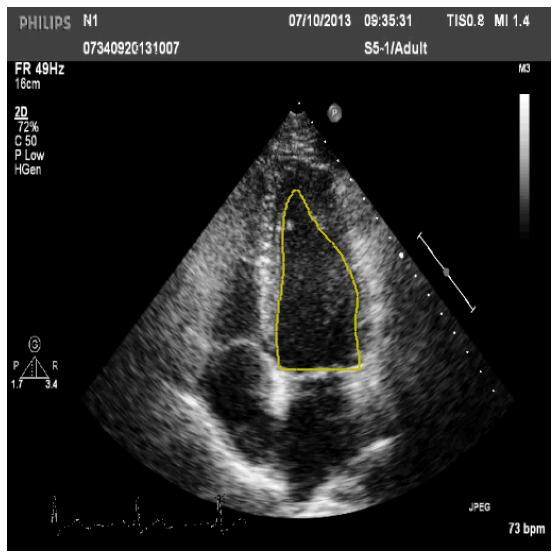

In [98]:
for i, obj in enumerate(data_lv.df_images.iterrows()):
    if obj[1]['category'] == 'Norma' and obj[1]['patient'] == '01' and obj[1]['obj_name'] == '15.bmp':
        print(i)
        break
cont = area2cont(np.squeeze(data_lv[i][1]))
y,x =np.where(cont!=0)
plt.figure(figsize=(10,10))
plt.imshow(np.squeeze(data_lv[i][0]),cmap=plt.cm.gray)
plt.scatter(x,y,c='y',s=5,marker='.')
plt.axis('off')
print('Площадь: ', len(np.where(np.squeeze(data_lv[i][1]) != 0)[0]))
plt.savefig('figures/pat_norma_syst.png', bbox_inches='tight', pad_inches=0,)